# Image Reconstruction

In this notebook I will be demonstrating Image Reconstruction using Linear Regression and Random Fourier Features and will be performing its qualitative as well as quantitative analysis.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(1)
torch.manual_seed(1)

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [34]:
img = torchvision.io.read_image("/kaggle/input/sample-files/samvad.jpg")
print(img.shape)

torch.Size([3, 600, 800])


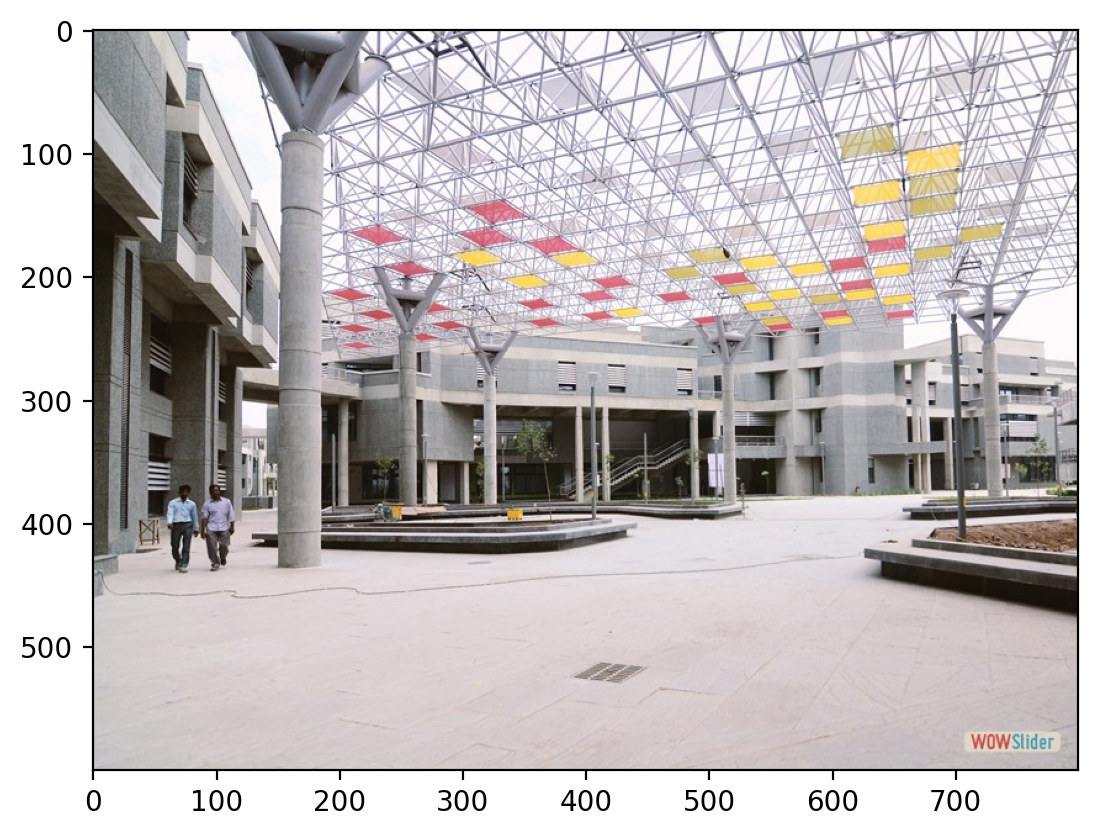

In [35]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [36]:
# Scaling down the image values to 0-1 using min-max scaler

from sklearn import preprocessing
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [37]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

(3, 600, 800)

In [38]:
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
print(img_scaled.shape)
print(img_scaled.max(), img_scaled.min())

torch.Size([3, 600, 800])
tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)


In [39]:
# Cropping the image to 300x300 px

crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 150, 0, 300, 300)
crop.shape

torch.Size([3, 300, 300])

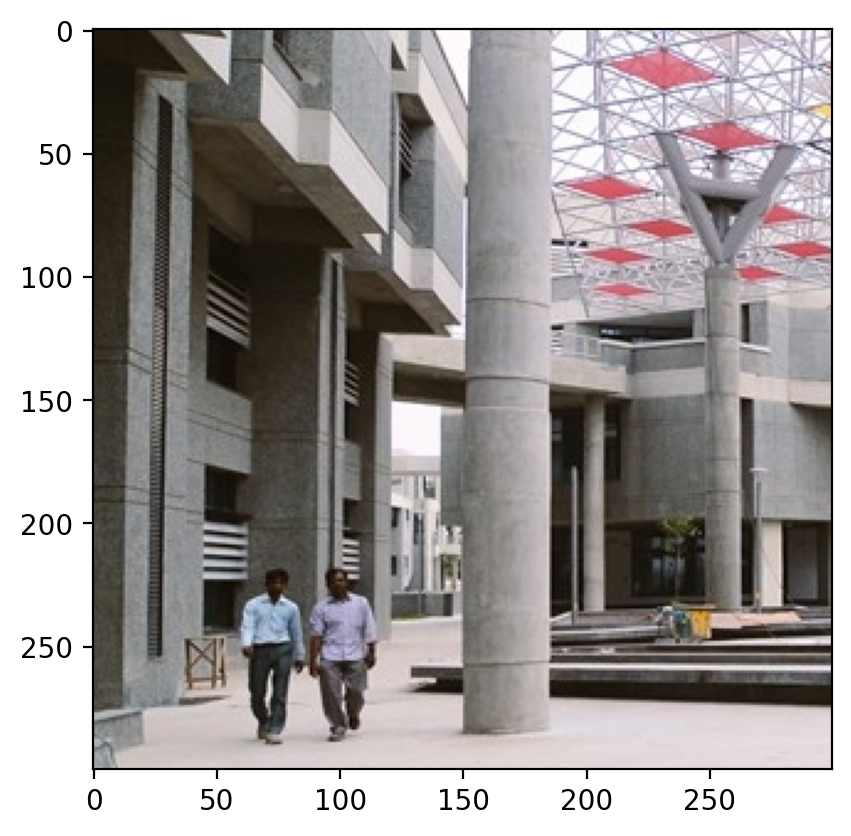

In [40]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [41]:
crop = crop.to(device)

# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [42]:
# Function to create the coordinate map for the orginal image (maps the coordinates the their respective RGB values)

def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Scale the dimensions of the image
    height = int(height * scale)
    width = int(width * scale)

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> h w c').float()
    return X, Y

In [43]:
# Creating the coordinate map
samvad_X, samvad_Y = create_coordinate_map(crop)

# MinMaxScaler from 0 to 1
scaler_X = preprocessing.MinMaxScaler().fit(samvad_X.cpu())

# Scale the X coordinates
samvad_X_scaled = scaler_X.transform(samvad_X.cpu())

# Move the scaled X coordinates to the GPU
samvad_X_scaled = torch.tensor(samvad_X_scaled).to(device)

# Set to dtype float32
samvad_X_scaled = samvad_X_scaled.float()

samvad_Y = samvad_Y.view(-1, 3)  # Shape becomes (90000, 3)

samvad_X_scaled.shape ,samvad_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [44]:
# Defining our Linear Regression model

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

model = LinearModel(2, 3)
model.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [45]:
# Defining the function to plot the reconstructed and original image side by side

def plot_reconstructed_and_original_image(original_img, model, X, title=""):
    """
    model: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        outputs = outputs.reshape(-1, 1) # Flatten
        scaler_X_pred = preprocessing.MinMaxScaler().fit(outputs)
        outputs = scaler_X_pred.transform(outputs)        # Scale prediction
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(original_img.permute(1, 2, 0))
    ax0.set_title("Original Image")
    
    ax1.imshow(outputs)
    ax1.set_title("Reconstructed Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()

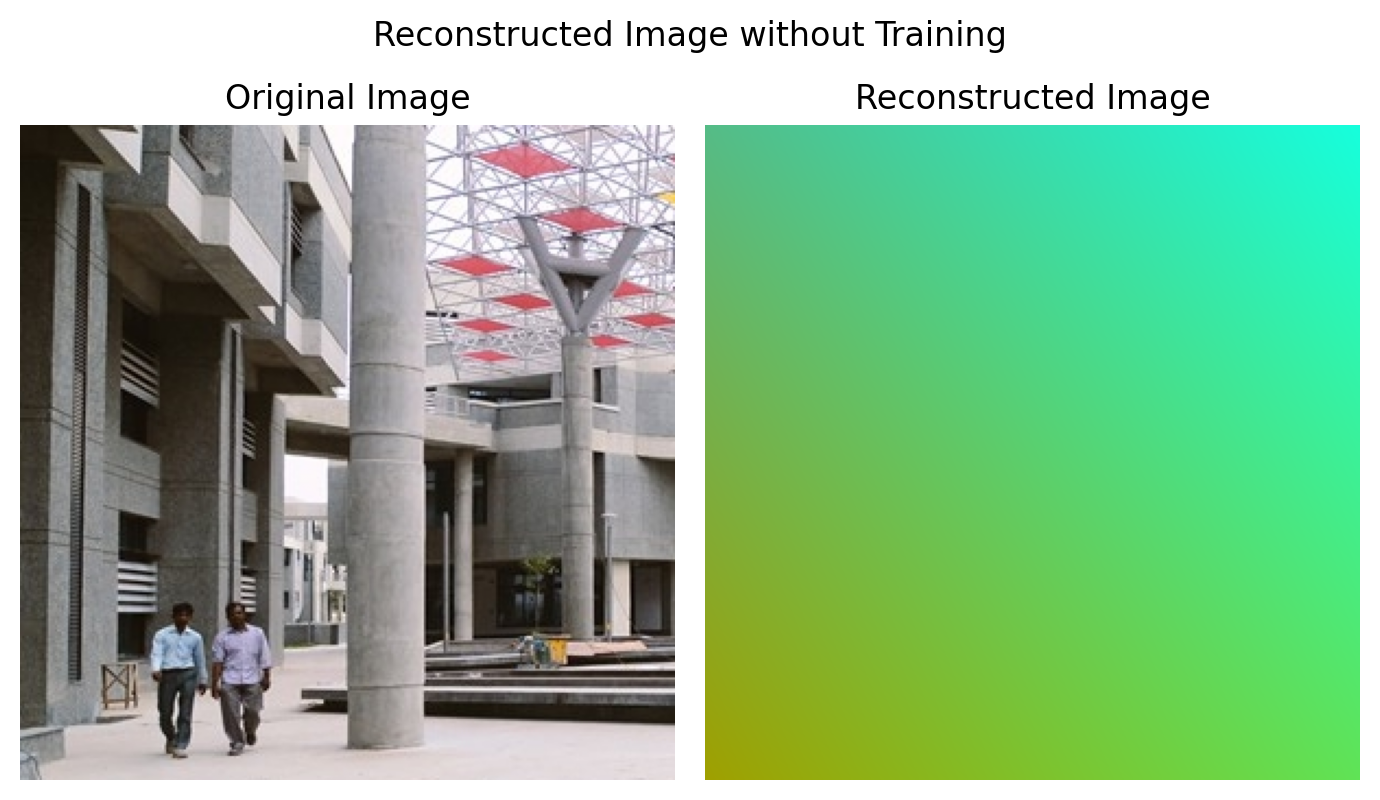

In [46]:
# Looking at the result of the untrained model before feature expansion

plot_reconstructed_and_original_image(crop, model, samvad_X_scaled, title="Reconstructed Image without Training")

In [47]:
# Defining the function to train the model

def train(model, lr, X, Y, epochs, verbose=True):
    """
    model: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch} loss = {loss.item():.6f}")
    print("Final loss =", loss.item())

In [48]:
# Training the model without feature expansion (on default features)

train(model, 0.06, samvad_X_scaled, samvad_Y, 2500)

Epoch 0 loss = 0.319071
Epoch 500 loss = 0.060577
Epoch 1000 loss = 0.060577
Epoch 1500 loss = 0.060577
Epoch 2000 loss = 0.060577
Final loss = 0.06057770922780037


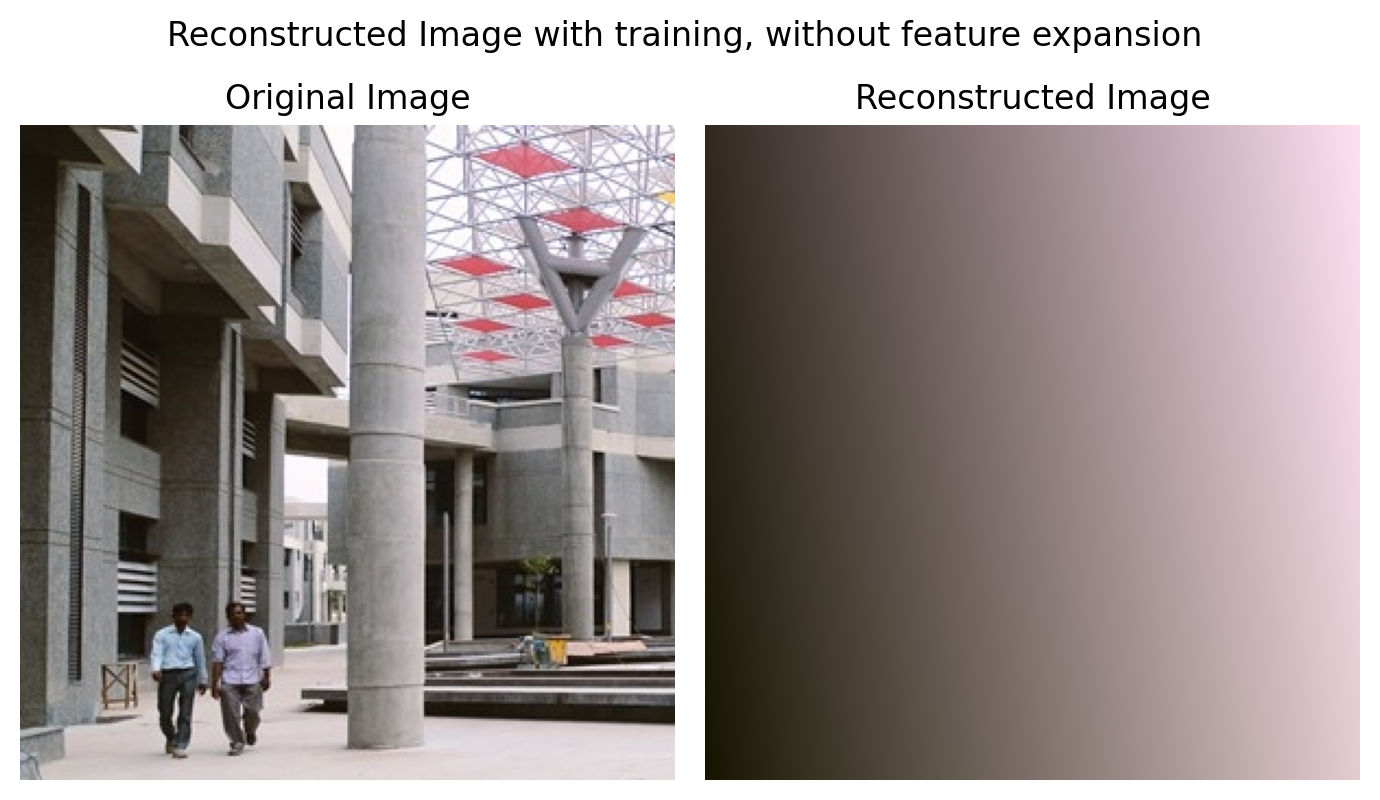

In [49]:
# Looking at the result of the trained model before feature expansion

plot_reconstructed_and_original_image(crop, model, samvad_X_scaled, title="Reconstructed Image with training, without feature expansion ")

In [50]:
# Defining the function to create RFF features

def create_rff_features(X, num_features, sigma):
    """
    X: torch.Tensor of shape (num_samples, 2)
    num_features: int
    sigma: float
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=1)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff

In [51]:
import gc
gc.collect()

10471

In [52]:
# Creating RFF features

n_features = [15000, 25000, 35000]
X_rffs = {}

for n in n_features:
    X_rff, rff = create_rff_features(samvad_X_scaled, n, 0.008)
    X_rffs[f"X_rff_{n}"] = (X_rff, rff)
    print(f"X_rff_{n}.shape = {X_rff.shape}")

X_rff_15000.shape = torch.Size([90000, 15000])
X_rff_25000.shape = torch.Size([90000, 25000])
X_rff_35000.shape = torch.Size([90000, 35000])


In [53]:
# Defining evaluation metrics

def RMSE(img1,img2):
    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))
    return rmse

def PSNR(RMSE, max_val=255):
    psnr = 20 * torch.log10(max_val / RMSE)
    return psnr.item()

Model - X_rff_15000
Epoch 0 loss = 0.327425
Epoch 500 loss = 0.005580
Epoch 1000 loss = 0.005561
Epoch 1500 loss = 0.005555
Epoch 2000 loss = 0.005550
Final loss = 0.005549730267375708


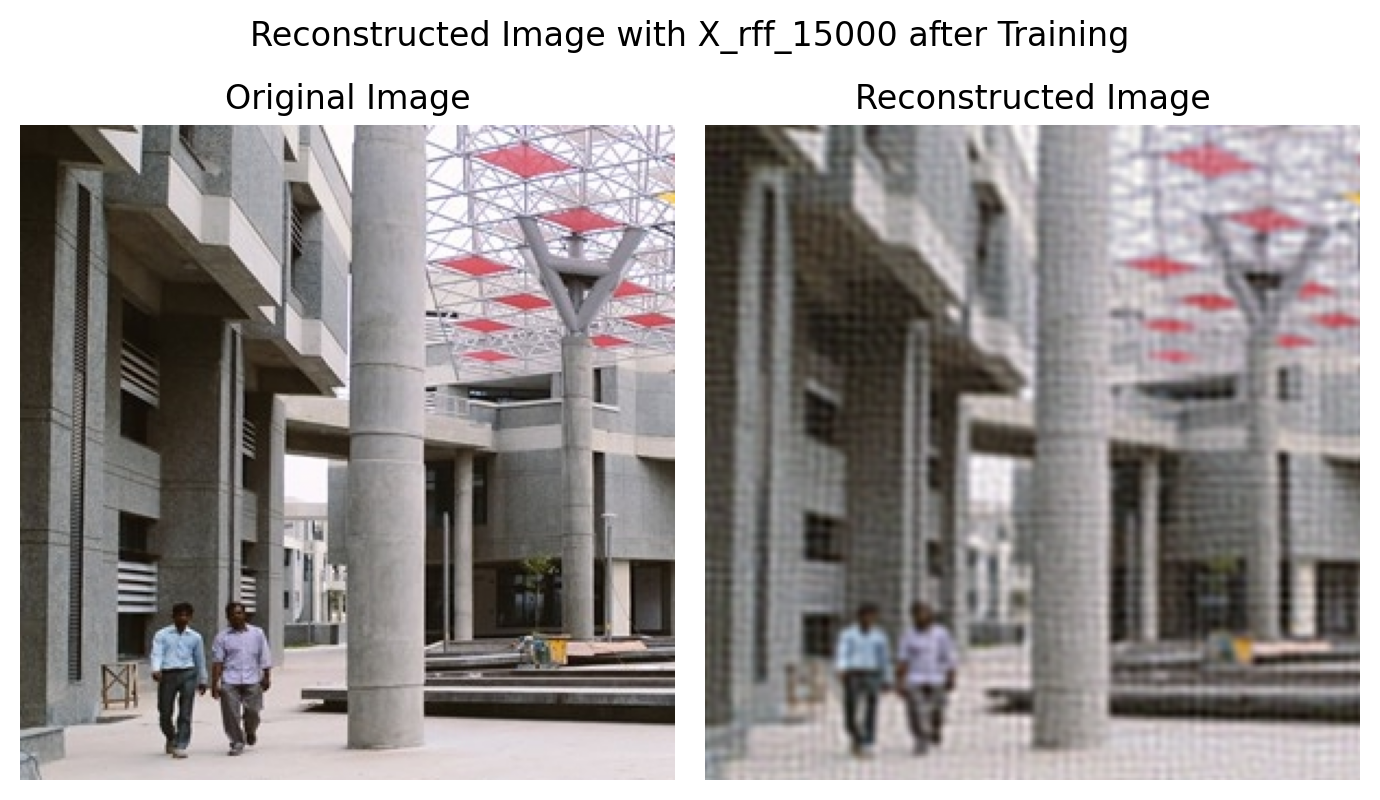

RMSE: 0.324437
PSNR: 9.777396 dB

Model - X_rff_25000
Epoch 0 loss = 0.330888
Epoch 500 loss = 0.005132
Epoch 1000 loss = 0.005121
Epoch 1500 loss = 0.005114
Epoch 2000 loss = 0.005114
Final loss = 0.0051110778003931046


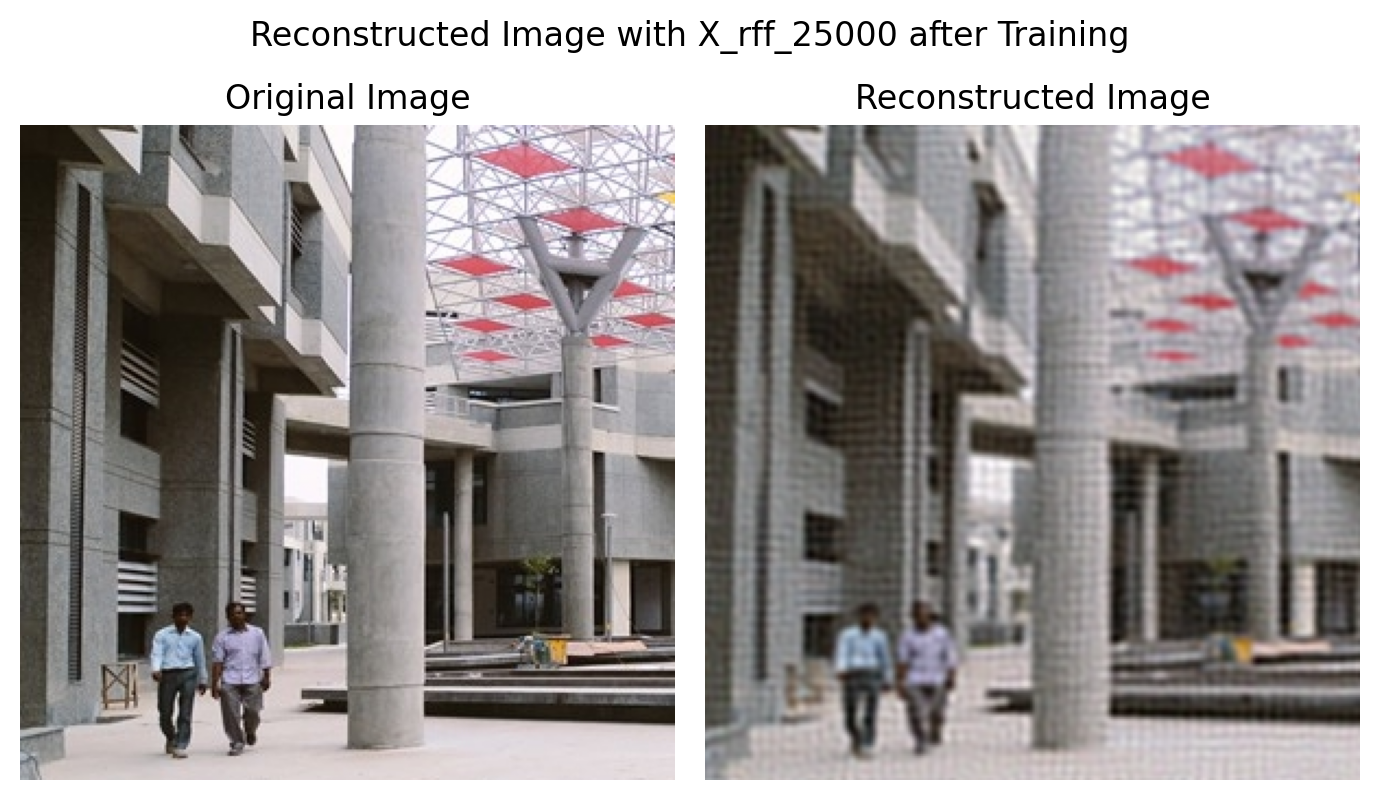

RMSE: 0.325807
PSNR: 9.740785 dB

Model - X_rff_35000
Epoch 0 loss = 0.329123
Epoch 500 loss = 0.004816
Epoch 1000 loss = 0.004816
Epoch 1500 loss = 0.004817
Epoch 2000 loss = 0.004806
Final loss = 0.0048081837594509125


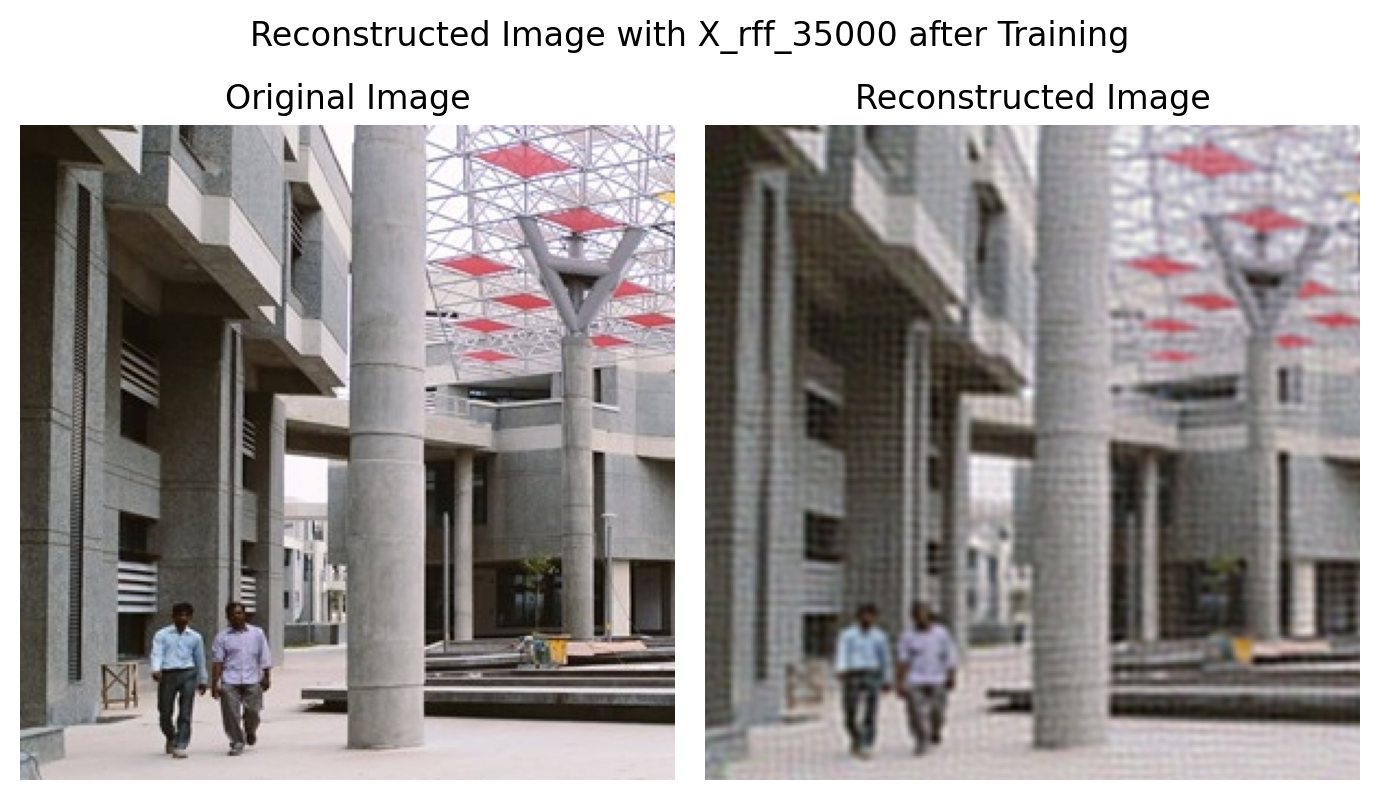

RMSE: 0.322938
PSNR: 9.817620 dB



In [60]:
# Training -> Inference -> Evaluation | Pipeline

for key, (X_feat, rff_instance) in X_rffs.items():
    model = LinearModel(X_feat.shape[1], 3)
    model.to(device)
    print(f"Model - {key}")

    # Train
    train(model, 0.06, X_feat, samvad_Y, 2500)

    # Visualize
    plot_reconstructed_and_original_image(crop, model, X_feat, title=f"Reconstructed Image with {key} after Training")

    model.eval()
    with torch.no_grad():
        # Inference with same RFF
        X_transformed = torch.tensor(rff_instance.transform(samvad_X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
    
        # Predict
        X_pred = model(X_transformed).to(device)
    
        # Scale prediction
        X_flat = X_pred.cpu().detach().numpy().reshape(-1, 1)
        scaler_X_pred = preprocessing.MinMaxScaler().fit(X_flat)
        X_scaled_flat = scaler_X_pred.transform(X_flat)
        X_pred_scaled = torch.tensor(X_scaled_flat.reshape(crop.shape), dtype=torch.float32).to(device)
    
        # Evaluation
        crop = crop.to(device)
        rmse = RMSE(crop, X_pred_scaled)
        psnr = PSNR(rmse, 1)
    
        print(f"RMSE: {rmse:.6f}")
        print(f"PSNR: {psnr:.6f} dB\n")

    del model, X_transformed, X_pred, X_flat, scaler_X_pred, X_scaled_flat, X_pred_scaled, rmse, psnr